In [21]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
import datetime as dt
from dotenv import load_dotenv
import yfinance as yf
from pandas_datareader import data as pdr

import warnings
warnings.simplefilter(action='ignore', category=Warning)

##import hvplot.pandas
##import holoviz
##import os, holoviews as hv
##os.environ['HV_DOC_HTML'] = 'true'

# Data Collection - Oil Prices (in USD) data.
In this notebook, we will load historical Oil data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [22]:
# Fetch oil data from Yahoo Finance
oil = yf.Ticker("CL=F")

# get stock info
oil.info

# get historical market data
df = oil.history(period="max")

In [23]:
# Drop the column not needed and assifn to a datafram
historical_df = df.drop(['Open',"High",'Low','Dividends','Stock Splits'],axis=1)

# Add a Returns Column to the dataframe
historical_df["Return"] = historical_df["Close"].pct_change() * 100

# Drop null values
historical_df.dropna(inplace=True)

# Create a lagged return using the shift function
historical_df['Lagged_Return'] = historical_df[['Return']].shift()

# Drop null values
historical_df.dropna(inplace=True)

historical_df.head()


,Close,Volume,Return,Lagged_Return
Date,,,,
2000-08-25,32.049999,44601,1.327854,-1.310453
2000-08-28,32.869999,46770,2.558501,1.327854
2000-08-29,32.720001,49131,-0.456336,2.558501
2000-08-30,33.400002,79214,2.078240,-0.456336
2000-08-31,33.099998,56895,-0.898213,2.078240


In [24]:
historical_df.tail()

,Close,Volume,Return,Lagged_Return
Date,,,,
2022-03-07,119.400002,576022,3.215769,7.439400
2022-03-08,123.699997,583106,3.601336,3.215769
2022-03-09,108.699997,594773,-12.126112,3.601336
2022-03-10,106.019997,437924,-2.465502,-12.126112
2022-03-11,109.330002,437924,3.122057,-2.465502


## Initial Time-Series Plotting

<AxesSubplot:title={'center':'Oil Prices: August 2000 - March 2022'}, xlabel='Date'>

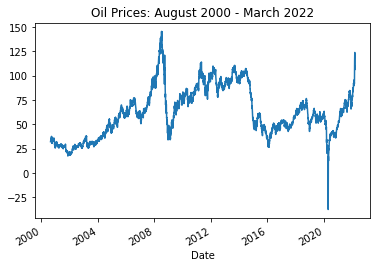

In [25]:
# Plot the Oil Close prices
historical_df.Close.plot(title="Oil Prices: August 2000 - March 2022")

In [26]:
##hv.extension('bokeh')
##hv.Curve([1, 2, 3])

<AxesSubplot:title={'center':'Oil Returns: August 2000 - March 2022'}, xlabel='Date'>

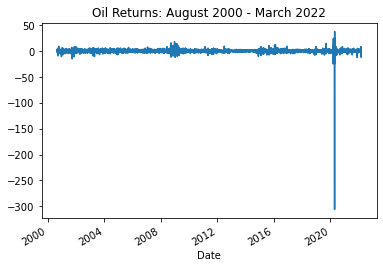

In [27]:
# Plot the Oil Returns
historical_df.Return.plot(title="Oil Returns: August 2000 - March 2022")

The dip in oil rates in 2020 was an abnormality and hence we will utilize data until Dec 2019 for our anlaysis. 

In [28]:
# Slice the data so it is until Dec 2019
historical_df = historical_df.loc[:'20191231']

<AxesSubplot:title={'center':'Oil Returns: August 2000 - December 2019'}, xlabel='Date'>

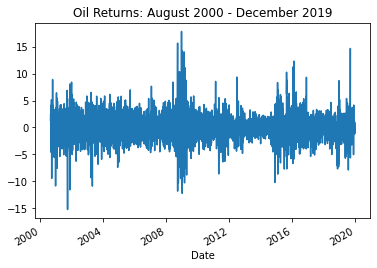

In [29]:
# Plot the Oil Returns after dropping 2020
historical_df.Return.plot(title="Oil Returns: August 2000 - December 2019")

---

# Pre-Processing

Split the data into training and testing data based on date range such that 75% falls in training set and 25% fals in testing set.  

In [30]:
# Create a train/test split for the dataset
##df_train = historical_df.loc['20000101':'20141231']
##df_test = historical_df.loc['20140101':'20191231'] 

len_train = round(len(historical_df) * 0.7) 

df_train = historical_df.iloc[:len_train]
df_test = historical_df.iloc[len_train:]

X_train = df_train["Lagged_Return"].to_frame()
X_test = df_test["Lagged_Return"].to_frame()

y_train = df_train["Return"]
y_test = df_test["Return"]

##X_train.head()

# Model: Linear Regression Model

In [31]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using  just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

## Make predictions using test data

In [32]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(X_test)

In [33]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Return"] = predictions

Results.describe()

,Return,Predicted Return
count,1457.000000,1457.000000
mean,-0.006108,0.064047
std,2.302781,0.074751
min,-10.232054,-0.412571
25%,-1.249003,0.024984
50%,0.047944,0.062296
75%,1.197352,0.104397
max,14.676396,0.396004


<AxesSubplot:title={'center':'Predicted Return vs Actual Return'}, xlabel='Date'>

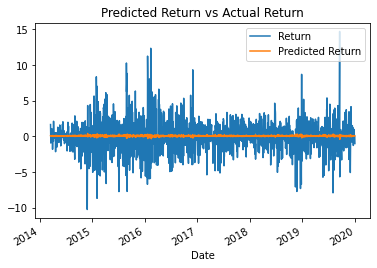

In [34]:
# Plot the predictions vs the true values
Results.plot(title = "Predicted Return vs Actual Return")
##Modify to use hvplot so it can be zoomed in

## In-Sample Performance for Linear Regression

Evaluate the model using in-sample data (X_train and y_train)

In [35]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 

# Construct a dataframe using just the "y" training data:
in_sample_results = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_results["In-sample Predictions"] = model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
mse = mean_squared_error(
    in_sample_results["Return"],
    in_sample_results["In-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = np.sqrt(mse)
print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}")

In-sample Root Mean Squared Error (RMSE): 2.3875321370121245


## Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [36]:
# Construct a dataframe using just the "y" test data:
out_sample_results = y_test.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
out_sample_results["Out-of-Sample Predictions"] = model.predict(X_test)

# Calculate out_of-sample mean_squared_error
mse = mean_squared_error(
    out_sample_results["Return"],
    out_sample_results["Out-of-Sample Predictions"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
out_sample_rmse = np.sqrt(mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {out_sample_rmse}")

Out-of-Sample Root Mean Squared Error (RMSE): 2.2972477077928053


## Comparison

In [37]:
# Print out-of-sample RMSE and rolling out-of-sample RMSE
print(f"Out-of-sample Root Mean Squared Error (RMSE): {in_sample_rmse}")
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {out_sample_rmse}")

Out-of-sample Root Mean Squared Error (RMSE): 2.3875321370121245
Out-of-Sample Root Mean Squared Error (RMSE): 2.2972477077928053


Comparing the two RMSE's, the RMSE from the single training window is 2.266, whereas it is 2.237 from the rolling out-of-sample model.

The rolling-out-of sample approach is an approach more appropriate to real life. The two values are close to each other which should suggest that our model is reasonably stable but the values are quite close to the standard deviation of dataset at 2.73 indicating room for improvements.

---

# Model: LSTM Predictor Using Closing Prices

In [38]:
# Set the random seed for reproducibility
# Note: This is used for model prototyping, but it is good practice to comment this out and run multiple experiments to evaluate your model.
from numpy.random import seed

seed(1)
from tensorflow import random

random.set_seed(2)


# Use the same dataset but assign to new variable names for LSTM
df = historical_df.drop(['Close','Volume', 'Lagged_Return'],axis=1)


In [39]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [40]:
# Creating the features (X) and target (y) data using the window_data() function.
window_size = 5

feature_column = 0
target_column = 0
X, y = window_data(df, window_size, feature_column, target_column)
print (f"X sample values:\n{X[:5]} \n")
print (f"y sample values:\n{y[:5]}")

X sample values:
[[ 1.32785358  2.55850145 -0.45633622  2.07824046 -0.89821269]
 [ 2.55850145 -0.45633622  2.07824046 -0.89821269  0.84592933]
 [-0.45633622  2.07824046 -0.89821269  0.84592933  1.25823294]
 [ 2.07824046 -0.89821269  0.84592933  1.25823294  3.40237146]
 [-0.89821269  0.84592933  1.25823294  3.40237146  1.08727056]] 

y sample values:
[[ 0.84592933]
 [ 1.25823294]
 [ 3.40237146]
 [ 1.08727056]
 [-4.61364558]]


In [41]:
# Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))
X_train_lstm = X[: split]
X_test_lstm = X[split:]
y_train_lstm = y[: split]
y_test_lstm = y[split:]

In [42]:
# Reshape the features for the model
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))
print (f"X_train sample values:\n{X_train_lstm[:5]} \n")
print (f"X_test sample values:\n{X_test_lstm[:5]}")

X_train sample values:
[[[ 1.32785358]
  [ 2.55850145]
  [-0.45633622]
  [ 2.07824046]
  [-0.89821269]]

 [[ 2.55850145]
  [-0.45633622]
  [ 2.07824046]
  [-0.89821269]
  [ 0.84592933]]

 [[-0.45633622]
  [ 2.07824046]
  [-0.89821269]
  [ 0.84592933]
  [ 1.25823294]]

 [[ 2.07824046]
  [-0.89821269]
  [ 0.84592933]
  [ 1.25823294]
  [ 3.40237146]]

 [[-0.89821269]
  [ 0.84592933]
  [ 1.25823294]
  [ 3.40237146]
  [ 1.08727056]]] 

X_test sample values:
[[[ 0.21430665]
  [ 0.70265017]
  [-0.81908946]
  [ 1.65170788]
  [ 0.67202188]]

 [[ 0.70265017]
  [-0.81908946]
  [ 1.65170788]
  [ 0.67202188]
  [-0.93653723]]

 [[-0.81908946]
  [ 1.65170788]
  [ 0.67202188]
  [-0.93653723]
  [ 0.03017075]]

 [[ 1.65170788]
  [ 0.67202188]
  [-0.93653723]
  [ 0.03017075]
  [ 0.14075949]]

 [[ 0.67202188]
  [-0.93653723]
  [ 0.03017075]
  [ 0.14075949]
  [-0.41164261]]]


## Build and Train the LSTM RNN

In [43]:
# Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [44]:
# Define the LSTM RNN model.
model = Sequential()

number_units = 5
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train_lstm.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [45]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [46]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 5)              140       
                                                                 
 dropout (Dropout)           (None, 5, 5)              0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 5)              220       
                                                                 
 dropout_1 (Dropout)         (None, 5, 5)              0         
                                                                 
 lstm_2 (LSTM)               (None, 5)                 220       
                                                                 
 dropout_2 (Dropout)         (None, 5)                 0         
                                                                 
 dense (Dense)               (None, 1)                 6

In [47]:
# Train the model
model.fit(X_train_lstm, y_train_lstm, epochs=10, shuffle=False, batch_size=1, verbose=1)

Epoch 1/10
3395/3395 [==============================] - 52s 12ms/step - loss: 5.7178
Epoch 2/10
3395/3395 [==============================] - 39s 12ms/step - loss: 5.7165
Epoch 3/10
3395/3395 [==============================] - 39s 11ms/step - loss: 5.7138
Epoch 4/10
3395/3395 [==============================] - 37s 11ms/step - loss: 5.7122
Epoch 5/10
3395/3395 [==============================] - 38s 11ms/step - loss: 5.7096
Epoch 6/10
3395/3395 [==============================] - 39s 11ms/step - loss: 5.7076
Epoch 7/10
3395/3395 [==============================] - 40s 12ms/step - loss: 5.7118
Epoch 8/10
3395/3395 [==============================] - 37s 11ms/step - loss: 5.7066
Epoch 9/10
3395/3395 [==============================] - 38s 11ms/step - loss: 5.7101
Epoch 10/10
3395/3395 [==============================] - 39s 11ms/step - loss: 5.6914


## Model Performance

In [55]:
# Evaluate the model
model.evaluate(X_test_lstm, y_test_lstm)

46/46 [==============================] - 0s 6ms/step - loss: 5.3153


5.3152594566345215

In [56]:
# Make some predictions
predicted = model.predict(X_test_lstm)

### Plotting Predicted Vs. Real Prices

In [57]:
predicted_prices = predicted
real_prices = y_test_lstm

In [58]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 

# Show the DataFrame's head
stocks.head()

ValueError: Shape of passed values is (1455, 2), indices imply (179, 2)

<AxesSubplot:xlabel='Date'>

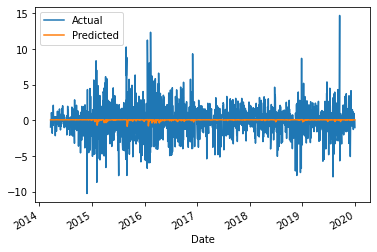

In [52]:
# Plot the real vs predicted prices as a line chart
stocks.plot()

---

# Classification 

In [79]:
# Convert Returns to 0 or 1
classification_df = (historical_df["Return"] > 0).astype(int)
classification_df

Date
2000-08-25    1
2000-08-28    1
2000-08-29    0
2000-08-30    1
2000-08-31    0
             ..
2019-12-24    1
2019-12-26    1
2019-12-27    1
2019-12-30    0
2019-12-31    0
Name: Return, Length: 4855, dtype: int32

In [80]:
# Read CSV data on Oil Sentiments from oil_sentiments.csv & put it into a dataframe
df = pd.read_csv(('headlines/oil_sentiments.csv'),index_col="date", infer_datetime_format=True, parse_dates=True)
df.head()
sentiment_df = df.filter(['compound']).dropna()
sentiment_df.head()

,compound
date,
2000-04-01,0.3400
2000-04-02,-0.5994
2000-04-04,0.0000
2000-04-05,0.0000
2000-04-06,0.0000


In [81]:
start_date = dt.datetime(2003,1,1)
end_date = dt.datetime(2011,12,31)

combined_oil_df = pd.concat([classification_df, sentiment_df], axis = 1, join="outer")
combined_oil_df["War_Period"] = 0
combined_oil_df["War_Period"].loc[ start_date : end_date ] = 1
combined_oil_df.dropna(inplace=True)
combined_oil_df.head(-1)



,Return,compound,War_Period
2000-08-25,1.0,0.0000,0
2000-08-28,1.0,0.0000,0
2000-08-29,0.0,0.1779,0
2000-08-30,1.0,0.0000,0
2000-08-31,0.0,0.0000,0
...,...,...,...
2019-12-13,1.0,0.0000,0
2019-12-16,1.0,-0.3400,0
2019-12-17,1.0,0.0000,0
2019-12-19,1.0,0.0000,0


---

# Model: Logistic Regression

In [117]:
# Set X to features and y to Return
X = combined_oil_df.drop(['Return'], axis=1)
y = combined_oil_df.filter(['Return'])

X.head(-1)

,compound,War_Period
2000-08-25,0.0000,0
2000-08-28,0.0000,0
2000-08-29,0.1779,0
2000-08-30,0.0000,0
2000-08-31,0.0000,0
...,...,...
2019-12-13,0.0000,0
2019-12-16,-0.3400,0
2019-12-17,0.0000,0
2019-12-19,0.0000,0


In [118]:
#Splitting Training and Testing
#Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))
X_train_lr = X[: split]
X_test_lr = X[split:]
y_train_lr = y[: split]
y_test_lr = y[split:]

X_train_lr.head()

,compound,War_Period
2000-08-25,0.0000,0
2000-08-28,0.0000,0
2000-08-29,0.1779,0
2000-08-30,0.0000,0
2000-08-31,0.0000,0


In [133]:
# Create the StandardScaler instance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit the Standard Scaler with the training data
# When fitting scaling functions, only train on the training dataset
scaler.fit(X_train_lr)

# Scale the features training and testing sets
X_train_lr_scaled = scaler.transform(X_train_lr)
X_test_lr_scaled = scaler.transform(X_test_lr)

X_train_lr_scaled


array([[ 0.0635567 , -1.68317058],
       [ 0.0635567 , -1.68317058],
       [ 0.68072673, -1.68317058],
       ...,
       [ 0.0635567 , -1.68317058],
       [-0.07070119, -1.68317058],
       [ 0.0635567 , -1.68317058]])

In [134]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_train_lr_scaled, y_train)

LogisticRegression(random_state=1)

In [135]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
y_pred = model.predict(X_test_lr_scaled)
balanced_accuracy_score(y_test_lr, y_pred)

0.491199265438247

In [136]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_lr, y_pred)

array([[150, 352],
       [162, 350]], dtype=int64)

In [137]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test_lr, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.48      0.30      0.68      0.37      0.45      0.20       502
        1.0       0.50      0.68      0.30      0.58      0.45      0.21       512

avg / total       0.49      0.49      0.49      0.47      0.45      0.20      1014



---

# Model: Random Forest Classifier

In [138]:
#Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))
X_train_rf = X[: split]
X_test_rf = X[split:]
y_train_rf = y[: split]
y_test_rf = y[split:]

X_train_rf.head()

,compound,War_Period
2000-08-25,0.0000,0
2000-08-28,0.0000,0
2000-08-29,0.1779,0
2000-08-30,0.0000,0
2000-08-31,0.0000,0


In [144]:
# Create the StandardScaler instance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit the Standard Scaler with the training data
# When fitting scaling functions, only train on the training dataset
scaler.fit(X_train_lr)

# Scale the features training and testing sets
X_train_rf_scaled = scaler.transform(X_train_lr)
X_test_rf_scaled = scaler.transform(X_test_lr)

X_train_lr_scaled


array([[ 0.0635567 , -1.68317058],
       [ 0.0635567 , -1.68317058],
       [ 0.68072673, -1.68317058],
       ...,
       [ 0.0635567 , -1.68317058],
       [-0.07070119, -1.68317058],
       [ 0.0635567 , -1.68317058]])

In [145]:
# Create a random forest classifier
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

In [146]:
# Fitting the model
rf_model = rf_model.fit(X_train_rf_scaled, y_train_rf)

In [147]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_rf_scaled)

In [148]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
y_pred = model.predict(X_test_rf_scaled)
balanced_accuracy_score(y_test_rf, y_pred)

0.491199265438247

In [149]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_rf, y_pred)

array([[150, 352],
       [162, 350]], dtype=int64)

In [150]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test_rf, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.48      0.30      0.68      0.37      0.45      0.20       502
        1.0       0.50      0.68      0.30      0.58      0.45      0.21       512

avg / total       0.49      0.49      0.49      0.47      0.45      0.20      1014



---

# Conclusions